In [19]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, get_scheduler
from torch.optim import AdamW
import pandas as pdf
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import nltk
from tqdm.auto import tqdm
import torch.nn.functional as F

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/mamdouh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mamdouh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Sampling English Sentences

In [20]:
path = "data_directories/final_data/english_train.txt"
with open(path, 'r', encoding='utf-8') as file:
    en_texts = file.read().strip()
    en_sentences = en_texts.split('\n')


In [21]:
import nltk
word_list = nltk.word_tokenize(en_texts)

unique_sorted_words = sorted(set(word_list))

# Save to vocab.txt
with open("vocab.txt", "w") as vocab_file:
    for word in unique_sorted_words:
        vocab_file.write(f"{word}\n")

print("✅ vocab.txt has been created!")


✅ vocab.txt has been created!


## Fine tuning gpt for generation

In [22]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import torch
import random
from transformers import logging
logging.set_verbosity_error()  # Only show critical errors

# === CONFIG ===
train_file = "data_directories/final_data/english_train.txt"      # Your 18k English lines
vocab_file = "vocab.txt"              # Optional: Wordlist
output_dir = "./gpt2-finetuned"       # Save directory
model_name = "gpt2"                   # or "distilgpt2" for smaller model

# === LOAD TOKENIZER AND MODEL ===
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Avoid padding issue
model = GPT2LMHeadModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# === LOAD AND PREPARE DATASET ===
def load_dataset(file_path):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=128
    )

train_dataset = load_dataset(train_file)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# === TRAINING ===
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_steps=100,
    report_to="none",
    save_strategy="no",

    # Still save the final model manually at the end
    save_total_limit=1,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator
)

print("Starting fine-tuning...")
trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print("✅ Finetuning complete!")

# === GENERATE NEW SENTENCES ===
def load_vocab():
    with open(vocab_file) as f:
        words = [w.strip() for w in f if w.strip()]
    return set(words)


def generate_sentences(n=10, max_len=50):
    model.eval()
    generated = []


    for _ in range(n):
        prompt = tokenizer.eos_token  # or use something like: "The"
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            output = model.generate(
                input_ids,
                do_sample=True,
                max_length=max_len,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                repetition_penalty=1.2,
                num_return_sequences=1,
                logits_processor=[
                    lambda input_ids, scores: scores
                ]
            )
        sentence = tokenizer.decode(output[0], skip_special_tokens=True)
        generated.append(sentence)

    return generated



# === Example: Generate 10 Sentences ===
print("\nGenerated sentences:\n")
for s in generate_sentences(n=10):
    print("-", s)


/home/mamdouh/anaconda3/envs/test/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Starting fine-tuning...
{'loss': 4.1049, 'grad_norm': 8.303450584411621, 'learning_rate': 4.853202846975089e-05, 'epoch': 0.08896797153024912}
{'loss': 3.6498, 'grad_norm': 8.856405258178711, 'learning_rate': 4.704922894424674e-05, 'epoch': 0.17793594306049823}
{'loss': 3.4749, 'grad_norm': 6.825517654418945, 'learning_rate': 4.556642941874259e-05, 'epoch': 0.2669039145907473}
{'loss': 3.3306, 'grad_norm': 7.1231584548950195, 'learning_rate': 4.408362989323844e-05, 'epoch': 0.35587188612099646}
{'loss': 3.2334, 'grad_norm': 7.878901481628418, 'learning_rate': 4.260083036773429e-05, 'epoch': 0.44483985765124556}
{'loss': 3.1716, 'grad_norm': 7.45532751083374, 'learning_rate': 4.111803084223013e-05, 'epoch': 0.5338078291814946}
{'loss': 3.0877, 'grad_norm': 6.144520282745361, 'learning_rate': 3.9635231316725976e-05, 'epoch': 0.6227758007117438}
{'loss': 2.9998, 'grad_norm': 5.63187837600708, 'learning_rate': 3.815243179122183e-05, 'epoch': 0.7117437722419929}
{'loss': 2.9856, 'grad_norm'

In [23]:
en_sentences = generate_sentences(n=18000)

In [24]:
import re

def clean_text(text):
    # Remove non-printable characters (e.g., weird unicode control chars)
    text = re.sub(r'\n', ' ', text)
    # Normalize multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [25]:
with open("generated.txt", 'w') as f:
    for sent in en_sentences:
        f.write(clean_text(sent).strip() + '\n')

## Generate english sentences

In [26]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# === Load the Fine-tuned Model and Tokenizer ===
model = GPT2LMHeadModel.from_pretrained("gpt2-finetuned").to("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-finetuned")

# === Controlled Sentence Generation (Top-p sampling) ===
def generate_sentence(prompt, max_length=50, top_p=0.95, temperature=1.0):
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate output using top-p sampling (nucleus sampling)
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        do_sample=True,
        top_p=top_p,  # Control diversity with top-p
        temperature=temperature,  # Control creativity with temperature
        top_k=50,  # Top-k filtering (optional, can be adjusted)
        repetition_penalty=1.2,  # Penalize repetition of the same phrase
        num_return_sequences=1  # Generate one sequence at a time
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# === Example: Generate Sentences ===
prompt = "Once upon a time"
generated_sentence = generate_sentence(prompt)
print("Generated sentence:", generated_sentence)


Generated sentence: Once upon a time when they were in Egypt or the passes of distant lands and who had not bowed down to my yoke I marched about conquering like an army Moving on from Calah there is trouble with it If one man at his disposal comes near


# Data Synthesis method

## Train EN to Ak Model

In [27]:
def tokenize_function(examples, max_len=200):
    eos_token_id = tokenizer.eos_token_id

    # Tokenize inputs and labels first, without padding
    inputs = tokenizer(
        examples["en"],
        truncation=True,
        max_length=max_len,
        padding=False
    )["input_ids"]

    labels = tokenizer(
        examples["tr"],
        truncation=True,
        max_length=max_len,
        padding=False
    )["input_ids"]

    inputs_with_eos = [seq + [eos_token_id] if eos_token_id not in seq else seq for seq in inputs]
    labels_with_eos = [seq + [eos_token_id] if eos_token_id not in seq else seq for seq in labels]

    # Pad
    padded_inputs = tokenizer.pad(
        {"input_ids": inputs_with_eos},
        padding="max_length",
        max_length=max_len,
        return_attention_mask=True
    )
    padded_labels = tokenizer.pad(
        {"input_ids": labels_with_eos},
        padding="max_length",
        max_length=max_len
    )

    input_ids = padded_inputs["input_ids"]
    attention_mask = padded_inputs["attention_mask"]
    label_ids = padded_labels["input_ids"]

    return {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "labels": label_ids
    }


### Download model for checkpoint

In [28]:
model_checkpoint_old = "Helsinki-NLP/opus-mt-ROMANCE-en"
model_checkpoint = "models/EN_TO_AK"
tokenizer_checkpoint = "models/EN_TO_AK"
tokenizer_checkpoint_old = "Helsinki-NLP/opus-mt-ROMANCE-en"


tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_old)
model = AutoModelForSeq2SeqLM.from_pretrained(tokenizer_checkpoint_old)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
print()

In [29]:
def load_data(en_file, tr_file):
    en_file = "data_directories/final_data/" + en_file
    tr_file = "data_directories/final_data/" + tr_file
    # en_file = "archive/" + en_file
    # tr_file = "archive/" + tr_file
    with open(en_file, 'r', encoding='utf-8') as file:
        en_texts = file.read().strip().split('\n')
    with open(tr_file, 'r', encoding='utf-8') as file:
        tr_texts = file.read().strip().split('\n')
    return pd.DataFrame({'en': en_texts, 'tr': tr_texts})

# train_data = load_data('new_combined_data.en', "new_combined_data.tr")
train_data = load_data("english_train.txt", "akkadian_train.txt")
val_data = load_data("english_val.txt", "akkadian_val.txt")
test_data = load_data("english_test.txt", "akkadian_test.txt")

In [30]:
# Here, we have sentence pairs
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

In [31]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data['input_ids']
        self.attention_mask = tokenized_data['attention_mask']
        self.labels = tokenized_data['labels']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


train_loader = DataLoader(CustomDataset(tokenized_train), batch_size=8, shuffle=True)
valid_loader = DataLoader(CustomDataset(tokenized_val), batch_size=8)
test_loader = DataLoader(CustomDataset(tokenized_test), batch_size=8)

Map:   0%|          | 0/31256 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [32]:
def save_model(model, tokenizer, optimizer, dataset_id):
    import os
    import json
    import torch

    save_path = "models/" + dataset_id
    os.makedirs(save_path, exist_ok=True)

    # Save model and tokenizer
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    # Save optimizer state only
    torch.save(optimizer.state_dict(), os.path.join(save_path, "optimizer.pt"))


In [33]:

import pandas as pd
import os
import json

def save_training_results(train_losses, val_losses, train_accuracies, val_accuracies, extension_name, output_dir="./results", create=False):
    """
    Saves training and validation metrics to a CSV file with a custom extension.
    If the file exists, appends new rows to it.
    """
    # Use local directory instead of Kaggle paths

    filename = os.path.join(output_dir, f"results_{extension_name}.csv")

    # Determine starting epoch number
    starting_epoch = 1

    if not create and os.path.exists(filename):
        # Check existing file for epoch count

        print("Checking existing file for epoch count...")
        existing_df = pd.read_csv(filename)
        if len(existing_df) > 0:
            starting_epoch = existing_df['Epoch'].max() + 1


    # Create DataFrame for new results with continuous epoch numbering
    new_results_df = pd.DataFrame({
        "Epoch": list(range(starting_epoch, starting_epoch + len(train_losses))),
        "Train Loss": train_losses,
        "Train Accuracy": train_accuracies,
        "Validation Loss": val_losses,
        "Validation Accuracy": val_accuracies
    })


    if create or not os.path.exists(filename):
        # Creating new file - just use new results
        combined_df = new_results_df
    else:
        # Append to existing data
        try:
            existing_df = pd.read_csv(filename)
            # Simply concatenate - no need to check for duplicates since we're using continuous numbering
            combined_df = pd.concat([existing_df, new_results_df], ignore_index=True)

        except Exception as e:
            combined_df = new_results_df

    # Save the combined DataFrame
    combined_df.to_csv(filename, index=False)

    return filename

In [34]:
optimizer = AdamW(model.parameters(), lr=5e-5)
# optimizer.load_state_dict(torch.load("models/baseline_label_smoothing_lr_scheduler/optimizer.pt"))
# scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
#                           num_training_steps=num_epochs * len(train_loader))

In [35]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

save_freq = 2
num_epochs = 100

# Double-check it's correct
pad_token_id = tokenizer.pad_token_id
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        labels = batch['labels']

        # Compute loss ignoring pad tokens
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            labels.view(-1),
            ignore_index=pad_token_id,
            reduction='mean',
            label_smoothing = 0.1
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item()

        # Compute accuracy ignoring pad tokens
        _, predicted = torch.max(logits, dim=-1)
        active_positions = (labels != -100) & (labels != pad_token_id)
        train_correct += (predicted[active_positions] == labels[active_positions]).sum().item()
        train_total += active_positions.sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch + 1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            labels = batch['labels']

            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                labels.view(-1),
                ignore_index=pad_token_id,
                reduction='mean'
            )
            val_loss += loss.item()

            _, predicted = torch.max(logits, dim=-1)
            active_positions = (labels != -100) & (labels != pad_token_id)
            val_correct += (predicted[active_positions] == labels[active_positions]).sum().item()
            val_total += active_positions.sum().item()

    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch + 1}: Validation Loss = {avg_val_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%")

    if (epoch+1) % save_freq == 0:
        save_model(model, tokenizer, optimizer, "EN_TO_AK")
        save_training_results(train_losses,val_losses, train_accuracies, val_accuracies, extension_name="EN_TO_AK")
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []


Training Epoch 1:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 1: Train Loss = 3.2667, Train Accuracy = 55.52%


Validation Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1: Validation Loss = 1.4453, Validation Accuracy = 67.71%


Training Epoch 2:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 2: Train Loss = 2.6181, Train Accuracy = 69.20%


Validation Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2: Validation Loss = 1.1614, Validation Accuracy = 73.86%


/home/mamdouh/anaconda3/envs/test/lib/python3.10/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Checking existing file for epoch count...


Training Epoch 3:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 3: Train Loss = 2.3939, Train Accuracy = 74.52%


Validation Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3: Validation Loss = 1.0175, Validation Accuracy = 77.18%


Training Epoch 4:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 4: Train Loss = 2.2613, Train Accuracy = 77.83%


Validation Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4: Validation Loss = 0.9486, Validation Accuracy = 78.95%
Checking existing file for epoch count...


Training Epoch 5:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 5: Train Loss = 2.1654, Train Accuracy = 80.27%


Validation Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5: Validation Loss = 0.8850, Validation Accuracy = 80.53%


Training Epoch 6:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 6: Train Loss = 2.0873, Train Accuracy = 82.26%


Validation Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6: Validation Loss = 0.8672, Validation Accuracy = 81.15%
Checking existing file for epoch count...


Training Epoch 7:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 7: Train Loss = 2.0276, Train Accuracy = 83.84%


Validation Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7: Validation Loss = 0.8433, Validation Accuracy = 81.97%


Training Epoch 8:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 8: Train Loss = 1.9776, Train Accuracy = 85.17%


Validation Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8: Validation Loss = 0.8165, Validation Accuracy = 82.64%
Checking existing file for epoch count...


Training Epoch 9:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 9: Train Loss = 1.9315, Train Accuracy = 86.34%


Validation Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9: Validation Loss = 0.8201, Validation Accuracy = 82.92%


Training Epoch 10:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 10: Train Loss = 1.8903, Train Accuracy = 87.42%


Validation Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10: Validation Loss = 0.8040, Validation Accuracy = 83.41%
Checking existing file for epoch count...


Training Epoch 11:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 11: Train Loss = 1.8568, Train Accuracy = 88.34%


Validation Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 11: Validation Loss = 0.7916, Validation Accuracy = 83.82%


Training Epoch 12:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 12: Train Loss = 1.8228, Train Accuracy = 89.20%


Validation Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 12: Validation Loss = 0.7981, Validation Accuracy = 83.92%
Checking existing file for epoch count...


Training Epoch 13:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 13: Train Loss = 1.7959, Train Accuracy = 89.95%


Validation Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 13: Validation Loss = 0.8106, Validation Accuracy = 84.07%


Training Epoch 14:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 14: Train Loss = 1.7716, Train Accuracy = 90.67%


Validation Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 14: Validation Loss = 0.8046, Validation Accuracy = 84.25%
Checking existing file for epoch count...


Training Epoch 15:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 15: Train Loss = 1.7482, Train Accuracy = 91.29%


Validation Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 15: Validation Loss = 0.8148, Validation Accuracy = 84.36%


Training Epoch 16:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 16: Train Loss = 1.7257, Train Accuracy = 91.93%


Validation Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 16: Validation Loss = 0.8288, Validation Accuracy = 84.33%
Checking existing file for epoch count...


Training Epoch 17:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 17: Train Loss = 1.7082, Train Accuracy = 92.43%


Validation Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 17: Validation Loss = 0.8337, Validation Accuracy = 84.44%


Training Epoch 18:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 18: Train Loss = 1.6885, Train Accuracy = 92.95%


Validation Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 18: Validation Loss = 0.8479, Validation Accuracy = 84.56%
Checking existing file for epoch count...


Training Epoch 19:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 19: Train Loss = 1.6735, Train Accuracy = 93.43%


Validation Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 19: Validation Loss = 0.8448, Validation Accuracy = 84.50%


Training Epoch 20:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 20: Train Loss = 1.6592, Train Accuracy = 93.85%


Validation Epoch 20:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 20: Validation Loss = 0.8544, Validation Accuracy = 84.58%
Checking existing file for epoch count...


Training Epoch 21:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 21: Train Loss = 1.6452, Train Accuracy = 94.27%


Validation Epoch 21:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 21: Validation Loss = 0.8651, Validation Accuracy = 84.79%


Training Epoch 22:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 22: Train Loss = 1.6334, Train Accuracy = 94.63%


Validation Epoch 22:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 22: Validation Loss = 0.8797, Validation Accuracy = 84.69%
Checking existing file for epoch count...


Training Epoch 23:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 23: Train Loss = 1.6216, Train Accuracy = 94.99%


Validation Epoch 23:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 23: Validation Loss = 0.8867, Validation Accuracy = 84.76%


Training Epoch 24:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 24: Train Loss = 1.6127, Train Accuracy = 95.28%


Validation Epoch 24:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 24: Validation Loss = 0.8821, Validation Accuracy = 84.87%
Checking existing file for epoch count...


Training Epoch 25:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 25: Train Loss = 1.6034, Train Accuracy = 95.59%


Validation Epoch 25:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 25: Validation Loss = 0.8929, Validation Accuracy = 84.81%


Training Epoch 26:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 26: Train Loss = 1.5957, Train Accuracy = 95.83%


Validation Epoch 26:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 26: Validation Loss = 0.9016, Validation Accuracy = 84.84%
Checking existing file for epoch count...


Training Epoch 27:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 27: Train Loss = 1.5877, Train Accuracy = 96.08%


Validation Epoch 27:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 27: Validation Loss = 0.9078, Validation Accuracy = 84.99%


Training Epoch 28:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 28: Train Loss = 1.5818, Train Accuracy = 96.30%


Validation Epoch 28:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 28: Validation Loss = 0.9254, Validation Accuracy = 84.92%
Checking existing file for epoch count...


Training Epoch 29:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 29: Train Loss = 1.5753, Train Accuracy = 96.48%


Validation Epoch 29:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 29: Validation Loss = 0.9346, Validation Accuracy = 84.96%


Training Epoch 30:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 30: Train Loss = 1.5698, Train Accuracy = 96.67%


Validation Epoch 30:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 30: Validation Loss = 0.9398, Validation Accuracy = 84.84%
Checking existing file for epoch count...


Training Epoch 31:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 31: Train Loss = 1.5645, Train Accuracy = 96.86%


Validation Epoch 31:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 31: Validation Loss = 0.9441, Validation Accuracy = 85.03%


Training Epoch 32:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 32: Train Loss = 1.5599, Train Accuracy = 96.99%


Validation Epoch 32:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 32: Validation Loss = 0.9388, Validation Accuracy = 85.03%
Checking existing file for epoch count...


Training Epoch 33:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 33: Train Loss = 1.5562, Train Accuracy = 97.09%


Validation Epoch 33:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 33: Validation Loss = 0.9516, Validation Accuracy = 84.94%


Training Epoch 34:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 34: Train Loss = 1.5513, Train Accuracy = 97.27%


Validation Epoch 34:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 34: Validation Loss = 0.9607, Validation Accuracy = 84.95%
Checking existing file for epoch count...


Training Epoch 35:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 35: Train Loss = 1.5481, Train Accuracy = 97.35%


Validation Epoch 35:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 35: Validation Loss = 0.9642, Validation Accuracy = 85.19%


Training Epoch 36:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 36: Train Loss = 1.5440, Train Accuracy = 97.49%


Validation Epoch 36:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 36: Validation Loss = 0.9622, Validation Accuracy = 85.15%
Checking existing file for epoch count...


Training Epoch 37:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 37: Train Loss = 1.5416, Train Accuracy = 97.55%


Validation Epoch 37:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 37: Validation Loss = 0.9656, Validation Accuracy = 85.24%


Training Epoch 38:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 38: Train Loss = 1.5387, Train Accuracy = 97.65%


Validation Epoch 38:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 38: Validation Loss = 0.9611, Validation Accuracy = 85.14%
Checking existing file for epoch count...


Training Epoch 39:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 39: Train Loss = 1.5359, Train Accuracy = 97.73%


Validation Epoch 39:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 39: Validation Loss = 0.9598, Validation Accuracy = 85.16%


Training Epoch 40:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 40: Train Loss = 1.5327, Train Accuracy = 97.83%


Validation Epoch 40:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 40: Validation Loss = 0.9780, Validation Accuracy = 85.07%
Checking existing file for epoch count...


Training Epoch 41:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 41: Train Loss = 1.5308, Train Accuracy = 97.90%


Validation Epoch 41:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 41: Validation Loss = 0.9788, Validation Accuracy = 85.24%


Training Epoch 42:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 42: Train Loss = 1.5280, Train Accuracy = 97.97%


Validation Epoch 42:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 42: Validation Loss = 0.9768, Validation Accuracy = 85.09%
Checking existing file for epoch count...


Training Epoch 43:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 43: Train Loss = 1.5269, Train Accuracy = 98.00%


Validation Epoch 43:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 43: Validation Loss = 0.9808, Validation Accuracy = 85.16%


Training Epoch 44:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 44: Train Loss = 1.5235, Train Accuracy = 98.09%


Validation Epoch 44:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 44: Validation Loss = 0.9831, Validation Accuracy = 85.05%
Checking existing file for epoch count...


Training Epoch 45:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 45: Train Loss = 1.5213, Train Accuracy = 98.15%


Validation Epoch 45:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 45: Validation Loss = 0.9833, Validation Accuracy = 85.10%


Training Epoch 46:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 46: Train Loss = 1.5199, Train Accuracy = 98.19%


Validation Epoch 46:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 46: Validation Loss = 0.9935, Validation Accuracy = 85.19%
Checking existing file for epoch count...


Training Epoch 47:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 47: Train Loss = 1.5174, Train Accuracy = 98.27%


Validation Epoch 47:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 47: Validation Loss = 0.9902, Validation Accuracy = 85.32%


Training Epoch 48:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 48: Train Loss = 1.5160, Train Accuracy = 98.29%


Validation Epoch 48:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 48: Validation Loss = 0.9926, Validation Accuracy = 85.32%
Checking existing file for epoch count...


Training Epoch 49:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 49: Train Loss = 1.5150, Train Accuracy = 98.32%


Validation Epoch 49:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 49: Validation Loss = 1.0024, Validation Accuracy = 85.26%


Training Epoch 50:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 50: Train Loss = 1.5125, Train Accuracy = 98.40%


Validation Epoch 50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 50: Validation Loss = 0.9956, Validation Accuracy = 85.30%
Checking existing file for epoch count...


Training Epoch 51:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 51: Train Loss = 1.5119, Train Accuracy = 98.42%


Validation Epoch 51:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 51: Validation Loss = 1.0081, Validation Accuracy = 85.22%


Training Epoch 52:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 52: Train Loss = 1.5100, Train Accuracy = 98.47%


Validation Epoch 52:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 52: Validation Loss = 1.0019, Validation Accuracy = 85.27%
Checking existing file for epoch count...


Training Epoch 53:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 53: Train Loss = 1.5089, Train Accuracy = 98.50%


Validation Epoch 53:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 53: Validation Loss = 1.0049, Validation Accuracy = 85.38%


Training Epoch 54:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 54: Train Loss = 1.5072, Train Accuracy = 98.53%


Validation Epoch 54:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 54: Validation Loss = 1.0119, Validation Accuracy = 85.39%
Checking existing file for epoch count...


Training Epoch 55:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 55: Train Loss = 1.5063, Train Accuracy = 98.56%


Validation Epoch 55:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 55: Validation Loss = 1.0090, Validation Accuracy = 85.24%


Training Epoch 56:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 56: Train Loss = 1.5058, Train Accuracy = 98.58%


Validation Epoch 56:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 56: Validation Loss = 1.0084, Validation Accuracy = 85.19%
Checking existing file for epoch count...


Training Epoch 57:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 57: Train Loss = 1.5038, Train Accuracy = 98.62%


Validation Epoch 57:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 57: Validation Loss = 1.0119, Validation Accuracy = 85.35%


Training Epoch 58:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 58: Train Loss = 1.5029, Train Accuracy = 98.64%


Validation Epoch 58:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 58: Validation Loss = 1.0103, Validation Accuracy = 85.33%
Checking existing file for epoch count...


Training Epoch 59:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 59: Train Loss = 1.5018, Train Accuracy = 98.68%


Validation Epoch 59:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 59: Validation Loss = 1.0144, Validation Accuracy = 85.44%


Training Epoch 60:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 60: Train Loss = 1.5007, Train Accuracy = 98.70%


Validation Epoch 60:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 60: Validation Loss = 1.0072, Validation Accuracy = 85.47%
Checking existing file for epoch count...


Training Epoch 61:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 61: Train Loss = 1.4998, Train Accuracy = 98.72%


Validation Epoch 61:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 61: Validation Loss = 1.0102, Validation Accuracy = 85.42%


Training Epoch 62:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 62: Train Loss = 1.4987, Train Accuracy = 98.74%


Validation Epoch 62:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 62: Validation Loss = 1.0103, Validation Accuracy = 85.46%
Checking existing file for epoch count...


Training Epoch 63:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 63: Train Loss = 1.4978, Train Accuracy = 98.78%


Validation Epoch 63:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 63: Validation Loss = 1.0221, Validation Accuracy = 85.35%


Training Epoch 64:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 64: Train Loss = 1.4970, Train Accuracy = 98.79%


Validation Epoch 64:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 64: Validation Loss = 1.0306, Validation Accuracy = 85.30%
Checking existing file for epoch count...


Training Epoch 65:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 65: Train Loss = 1.4960, Train Accuracy = 98.80%


Validation Epoch 65:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 65: Validation Loss = 1.0286, Validation Accuracy = 85.25%


Training Epoch 66:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 66: Train Loss = 1.4949, Train Accuracy = 98.84%


Validation Epoch 66:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 66: Validation Loss = 1.0239, Validation Accuracy = 85.46%
Checking existing file for epoch count...


Training Epoch 67:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 67: Train Loss = 1.4944, Train Accuracy = 98.85%


Validation Epoch 67:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 67: Validation Loss = 1.0252, Validation Accuracy = 85.44%


Training Epoch 68:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 68: Train Loss = 1.4932, Train Accuracy = 98.88%


Validation Epoch 68:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 68: Validation Loss = 1.0341, Validation Accuracy = 85.37%
Checking existing file for epoch count...


Training Epoch 69:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 69: Train Loss = 1.4928, Train Accuracy = 98.88%


Validation Epoch 69:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 69: Validation Loss = 1.0297, Validation Accuracy = 85.29%


Training Epoch 70:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 70: Train Loss = 1.4919, Train Accuracy = 98.92%


Validation Epoch 70:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 70: Validation Loss = 1.0316, Validation Accuracy = 85.54%
Checking existing file for epoch count...


Training Epoch 71:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 71: Train Loss = 1.4911, Train Accuracy = 98.93%


Validation Epoch 71:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 71: Validation Loss = 1.0337, Validation Accuracy = 85.36%


Training Epoch 72:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 72: Train Loss = 1.4903, Train Accuracy = 98.95%


Validation Epoch 72:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 72: Validation Loss = 1.0420, Validation Accuracy = 85.28%
Checking existing file for epoch count...


Training Epoch 73:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 73: Train Loss = 1.4899, Train Accuracy = 98.95%


Validation Epoch 73:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 73: Validation Loss = 1.0349, Validation Accuracy = 85.38%


Training Epoch 74:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 74: Train Loss = 1.4893, Train Accuracy = 98.96%


Validation Epoch 74:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 74: Validation Loss = 1.0353, Validation Accuracy = 85.33%
Checking existing file for epoch count...


Training Epoch 75:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 75: Train Loss = 1.4878, Train Accuracy = 99.00%


Validation Epoch 75:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 75: Validation Loss = 1.0431, Validation Accuracy = 85.37%


Training Epoch 76:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 76: Train Loss = 1.4880, Train Accuracy = 98.99%


Validation Epoch 76:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 76: Validation Loss = 1.0396, Validation Accuracy = 85.39%
Checking existing file for epoch count...


Training Epoch 77:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 77: Train Loss = 1.4874, Train Accuracy = 99.01%


Validation Epoch 77:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 77: Validation Loss = 1.0322, Validation Accuracy = 85.45%


Training Epoch 78:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 78: Train Loss = 1.4863, Train Accuracy = 99.04%


Validation Epoch 78:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 78: Validation Loss = 1.0486, Validation Accuracy = 85.36%
Checking existing file for epoch count...


Training Epoch 79:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 79: Train Loss = 1.4859, Train Accuracy = 99.04%


Validation Epoch 79:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 79: Validation Loss = 1.0472, Validation Accuracy = 85.30%


Training Epoch 80:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 80: Train Loss = 1.4853, Train Accuracy = 99.06%


Validation Epoch 80:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 80: Validation Loss = 1.0445, Validation Accuracy = 85.50%
Checking existing file for epoch count...


Training Epoch 81:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 81: Train Loss = 1.4852, Train Accuracy = 99.05%


Validation Epoch 81:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 81: Validation Loss = 1.0417, Validation Accuracy = 85.45%


Training Epoch 82:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 82: Train Loss = 1.4842, Train Accuracy = 99.06%


Validation Epoch 82:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 82: Validation Loss = 1.0561, Validation Accuracy = 85.41%
Checking existing file for epoch count...


Training Epoch 83:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 83: Train Loss = 1.4844, Train Accuracy = 99.06%


Validation Epoch 83:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 83: Validation Loss = 1.0541, Validation Accuracy = 85.33%


Training Epoch 84:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 84: Train Loss = 1.4833, Train Accuracy = 99.10%


Validation Epoch 84:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 84: Validation Loss = 1.0492, Validation Accuracy = 85.40%
Checking existing file for epoch count...


Training Epoch 85:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 85: Train Loss = 1.4829, Train Accuracy = 99.11%


Validation Epoch 85:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 85: Validation Loss = 1.0534, Validation Accuracy = 85.47%


Training Epoch 86:   0%|          | 0/3907 [00:00<?, ?it/s]

Epoch 86: Train Loss = 1.4827, Train Accuracy = 99.10%


Validation Epoch 86:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 86: Validation Loss = 1.0468, Validation Accuracy = 85.49%
Checking existing file for epoch count...


Training Epoch 87:   0%|          | 0/3907 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [36]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

padding_token_id = tokenizer.pad_token_id # Define the padding token ID
model.to(device)
model.eval()
total_tokens = 0
correct_tokens = 0

for batch in tqdm(test_loader, desc="Evaluating Token-Level Accuracy on Test Set"):
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits
        labels = batch["labels"]

        # Get the predicted token IDs
        predicted = torch.argmax(logits, dim=-1)

        # Create mask to ignore padding tokens (padding_token_id) and special tokens like -100
        mask = (labels != -100) & (labels != padding_token_id)

        # Count correct predictions
        correct_tokens += ((predicted == labels) & mask).sum().item()
        total_tokens += mask.sum().item()

token_accuracy = 100 * correct_tokens / total_tokens
print(f"Token-Level Accuracy on Test Set: {token_accuracy:.2f}%")


Evaluating Token-Level Accuracy on Test Set: 100%|██████████| 125/125 [00:03<00:00, 33.98it/s]

Token-Level Accuracy on Test Set: 85.77%


## Convert Generated English sentences to Akkadian

In [33]:
model_checkpoint = "models/EN_TO_AK"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)


In [39]:
with open("generated.txt", "r") as f:
    en_sent = f.read().strip().split("\n")

In [35]:
len(en_sent)

18000

In [36]:
lens = [len(x.split()) for x in en_sent]

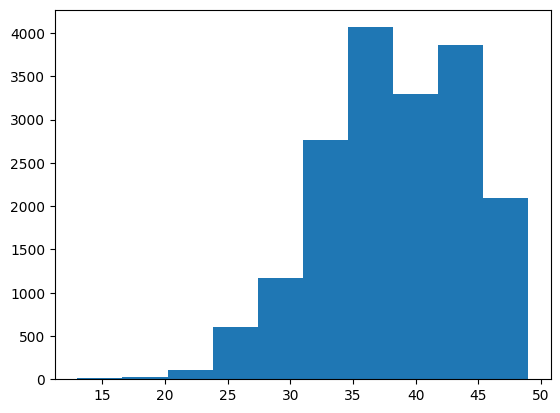

In [37]:
import matplotlib.pyplot as plt
plt.hist(lens)
plt.show()

In [40]:
def tokenize_inputs(examples):
    model_inputs = tokenizer(examples["en"], truncation=True, padding="max_length", max_length=200)
    return model_inputs

In [41]:
input_dataset = Dataset.from_dict({'en':en_sent})

In [42]:
tokenized_input = input_dataset.map(tokenize_inputs, batched= True)

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

In [43]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data['input_ids']
        self.attention_mask = tokenized_data['attention_mask']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
        }


train_input = DataLoader(CustomDataset(tokenized_input), batch_size=16, shuffle=True)

### Sample translations

In [ ]:
from tqdm import tqdm

model.eval()
model.to(device)

print("\nSample Translations:\n" + "=" * 60)

# Limit the number of printed samples
max_display = 5
displayed = 0

for batch in tqdm(train_input, desc="Translating Test Set"):
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        generated_tokens = model.generate(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            max_length=200,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )
    # Decode predictions and ground truth labels
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    for pred in decoded_preds:
        if displayed >= max_display:
            break
        print(f"🔹 Prediction: {pred}")
        print("-" * 60)
        displayed += 1

    if displayed >= max_display:
        break


### Generate Akkadian translations

In [44]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
total_pred=  []
for batch in tqdm(train_input, desc="Translating Test Set"):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        generated_tokens = model.generate(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            max_length=200,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )
    # Decode predictions and ground truth labels
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    total_pred.append(decoded_preds)
flattened = [item for sublist in total_pred for item in sublist]

Translating Test Set: 100%|██████████| 1125/1125 [12:31<00:00,  1.50it/s]


### Combine old EN-AK pairs with generated ones

In [45]:
def load_data(en_file, tr_file):
    en_file = "data_directories/final_data/" + en_file
    tr_file = "data_directories/final_data/" + tr_file
    # en_file = "archive/" + en_file
    # tr_file = "archive/" + tr_file
    with open(en_file, 'r', encoding='utf-8') as file:
        en_texts = file.read().strip().split('\n')
    with open(tr_file, 'r', encoding='utf-8') as file:
        tr_texts = file.read().strip().split('\n')
    return pd.DataFrame({'en': en_texts, 'tr': tr_texts})


train_data = load_data("english_train.txt", "akkadian_train.txt")

In [46]:
with open("generated.txt", 'r') as f:
    en_sent = f.read().strip().split('\n')

In [47]:
gen_dataset = pd.DataFrame({"en" : en_sent, "tr": flattened})

In [48]:
df = pd.concat([train_data, gen_dataset])

In [49]:
import os
os.makedirs("data_directories/final_data/full_data", exist_ok=True)

df['en'].to_csv("data_directories/final_data/new_combined_data_english.txt", index=False, header=False)

# Write Akkadian (or target language) sentences
df['tr'].to_csv("data_directories/final_data/new_combined_data_akkadian.txt", index=False, header=False)
